In [236]:
import pandas as pd
from sklearn import preprocessing
import warnings
import matplotlib.pyplot as plt
import math
import numpy as np
import sympy as sp
import scipy as sc
import statsmodels
from scipy.interpolate import interp1d

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [237]:
def compute_transition_matrix(data, n, step = 1):
    P = np.zeros((n, n))
    N = np.zeros((n, n))
    m = len(data)
    for i in range(m):
        initial, final = i, i + step
        if final < m:
            P[data[initial]][data[final]] += 1
            N[data[initial]][data[final]] += 1
    sums = np.sum(P, axis = 1)
    for i in range(n):
        for j in range(n):
            P[i][j] = round(P[i][j] / sums[i], 2)
    return P, N


In [238]:
def compute_transition_matrix_fast(data, n, step = 1):
    t = np.array(data)
    step = step
    total_inds = t.size - (step + 1) + 1
    t_strided = np.lib.stride_tricks.as_strided(
                                    t,
                                    shape = (total_inds, 2),
                                    strides = (t.strides[0], step * t.strides[0]))
    
    inds, counts = np.unique(t_strided, axis = 0, return_counts = True)

    P = np.zeros((n, n))
    N = np.zeros((n, n))
    P[inds[:, 0], inds[:, 1]] = counts
    N[inds[:, 0], inds[:, 1]] = counts
    
    sums = P.sum(axis = 1)
    
    P[sums != 0] = P[sums != 0] / sums[sums != 0][:, None]
    
    return P, N


In [239]:
def compute_stationary_distribution(P):
    # return sp.Matrix(np.vstack((np.hstack((P.T - np.identity(P.shape[0]), np.zeros((P.shape[0], 1)))), np.ones(P.shape[0] + 1)))).rref()[0].col(-1)[:-1]
    A = np.vstack((P.T - np.identity(P.shape[0]), np.ones((P.shape[0]))))
#     print(A.shape)
    b = np.zeros((P.shape[0] + 1, 1))
#     print(b.shape)
#     print(b)
    b[-1] = 1
#     print(b)
#     display(sp.Matrix(A))
    return np.linalg.lstsq(A, b)[0]

In [240]:
def compute_auto_correlation(x, k):
    x_bar = np.average(x)
    num, den = 0, 0
    m, M = x.index.min(), x.index.max()
    
    for i in range(m, M - k + 1):
        num += ((x[i] - x_bar) * (x[i + k] - x_bar))
    
    for i in range(m, M):
        den += (x[i] - x_bar)**2
    
    return num / den

In [241]:
def get_test_statistic(N, Q, i):
    n, N2 = N.shape[0], N[i][Q[i] > 0]
    S = N2.sum()
    chi2 = sc.stats.chi2.ppf(q = 0.95, df = len(N2) - 1)
    ts = 0.0
#     print(n, S)
    if S > 0:
        for j in range(n):
            if Q[i][j] > 0:
                observed = N[i][j]
                expected = S * Q[i][j]
                ts += ((observed - expected)**2 / expected)
    return chi2, ts

In [246]:
def pretty_print_matrix(a):
    for row in a:
        for col in row:
            print("{:8.3f}".format(col), end=" ")
        print("")

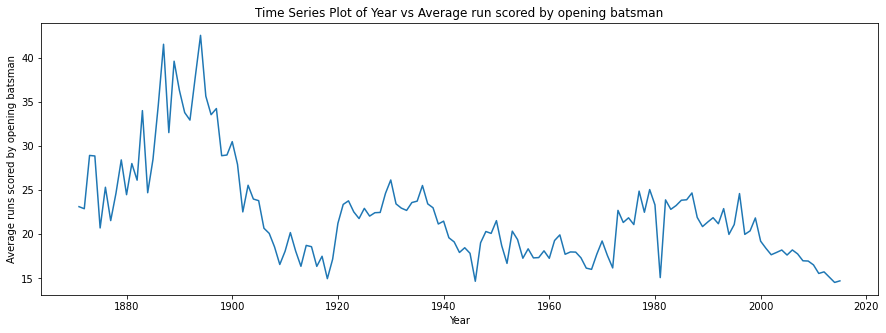

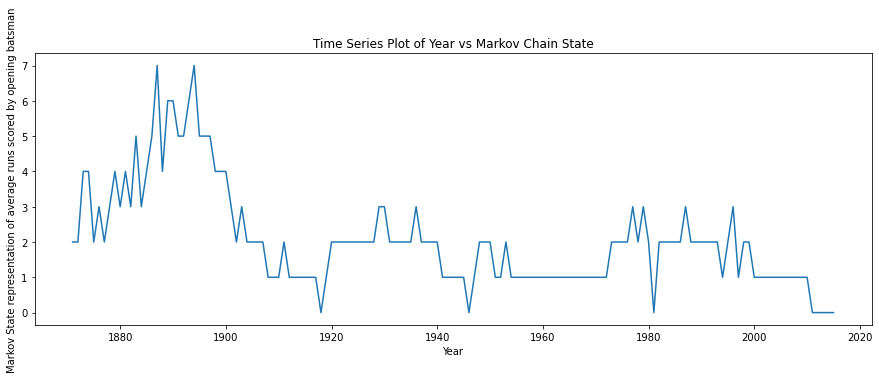

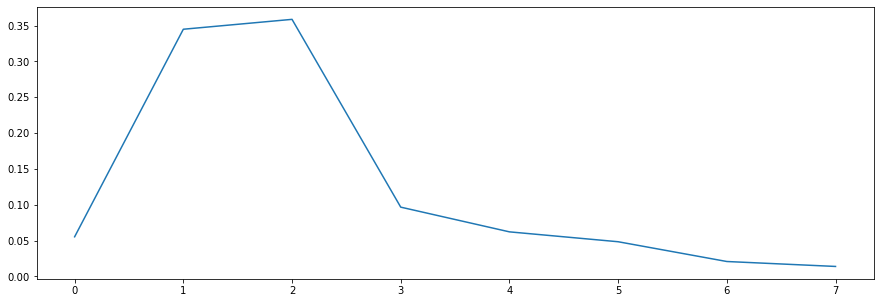

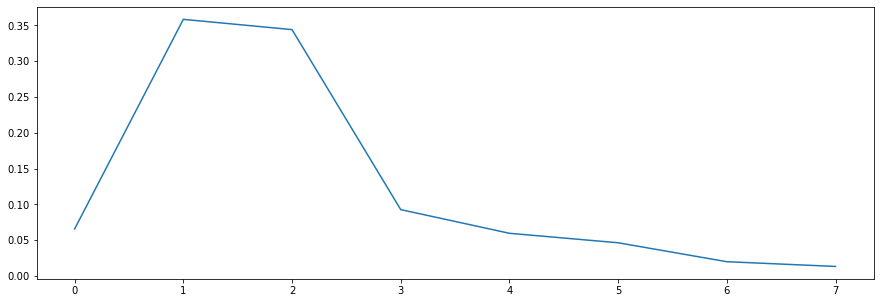

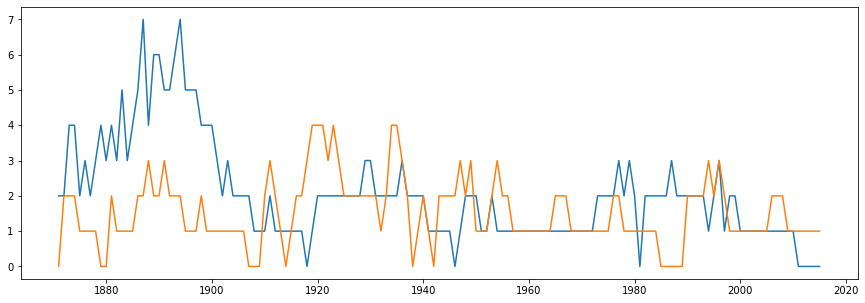

Matrix([
[ 1.01475463920112,     1.00221744131228],
[0.840813417131264,    0.656761122909823],
[0.798729992957791,     0.39241071497126],
[ 0.78483685661044,    0.216848177444444],
[0.746654125913757,    0.154288384078034],
[ 0.68028110739095,    0.103641195268435],
[0.649038260794076,   0.0610656310417215],
[ 0.61064015438395,   0.0104184422321219],
[0.551637771387839,  -0.0279264773856305],
[0.503260590254884, -0.00592904494925531]])

'(Decision Threshold, TS for state 0) = (5.991464547107979, 68.66517857142856)'

'(Decision Threshold, TS for state 1) = (5.991464547107979, 122.26607437641724)'

'(Decision Threshold, TS for state 2) = (9.487729036781154, 603.6972237529166)'

'(Decision Threshold, TS for state 3) = (9.487729036781154, 545.3677394034539)'

'(Decision Threshold, TS for state 4) = (9.487729036781154, 55.824074074074076)'

'(Decision Threshold, TS for state 5) = (9.487729036781154, 114.63492063492063)'

'(Decision Threshold, TS for state 6) = (5.991464547107979, 21.999999999999996)'

'(Decision Threshold, TS for state 7) = (3.841458820694124, 2.5)'

In [242]:
GAP = 4

df = pd.read_csv("./Baseball/Batting.csv")
df = df[(df.stint == 1) & (df.R >= 0)]

all_years_runs = pd.pivot_table(df, index = ["yearID"], values = ["R"], aggfunc = np.average)
all_years_runs = all_years_runs.sort_values(by = ["yearID"])

old_runs = all_years_runs["R"]

plt.figure(figsize = (15, 5))
plt.title("Time Series Plot of Year vs Average run scored by opening batsman")
plt.xlabel("Year")
plt.ylabel("Average runs scored by opening batsman")
plt.plot(old_runs)
plt.show()

r_min, r_max = old_runs.min(), old_runs.max()

all_years_runs["R"] = (all_years_runs["R"]) // GAP + 1

m, M = all_years_runs.index.min(), all_years_runs.index.max()
all_years_runs["RCount"] = all_years_runs["R"].map(all_years_runs["R"].value_counts())
all_years_runs["RCount_norm"] = all_years_runs["R"].map(all_years_runs["R"].value_counts(normalize = True))
label_encoder = preprocessing.LabelEncoder()
all_years_runs["MC_R"] = label_encoder.fit_transform(all_years_runs["R"])


run_series = all_years_runs["MC_R"]

plt.figure(figsize = (15, 5))
plt.title("Time Series Plot of Year vs Markov Chain State")
plt.xlabel("Year")
plt.ylabel("Markov State representation of average runs scored by opening batsman")
plt.plot(run_series)
plt.show()

all_years_runs_no_dup = all_years_runs.drop_duplicates().sort_values(by = "R")

plt.figure(figsize = (15, 5))
plt.plot(all_years_runs_no_dup["MC_R"], all_years_runs_no_dup["RCount_norm"])
plt.show()


total_states = all_years_runs_no_dup["R"].count()
P, N1 = compute_transition_matrix_fast(run_series.tolist(), total_states, 1)
W = compute_stationary_distribution(P)

plt.figure(figsize = (15, 5))
plt.plot(all_years_runs_no_dup["MC_R"], W)
plt.show()

m_MC_R, M_MC_R = all_years_runs_no_dup["MC_R"].min(), all_years_runs_no_dup["MC_R"].max()

new_run_series = pd.Series()
new_run_series.at[m] = np.random.choice(np.arange(m_MC_R, M_MC_R + 1))
for i in range(m + 1, M + 1):
    prev = new_run_series[i - 1]
    curr = np.random.choice(np.arange(m_MC_R, M_MC_R + 1), p = P[prev])
    new_run_series.at[i] = curr

plt.figure(figsize = (15, 5))
plt.plot(run_series)
plt.plot(new_run_series)
plt.show()


R = np.zeros((10, 2))

for i in range(10):
    R[i][0] = compute_auto_correlation(run_series, i)
    R[i][1] = compute_auto_correlation(new_run_series, i)

display(sp.Matrix(R))

print()

Q_emp, N2 = compute_transition_matrix_fast(run_series.tolist(), total_states, 2)

Q_th = P**2

decision_threshold = sc.stats.chi2.ppf(q = 0.95, df = total_states - 1)

# display("Decision Threshold (chi^2) = " + str(decision_threshold))
# print()

for i in range(total_states):
    display("(Decision Threshold, TS for state " + str(i) + ") = " + str(get_test_statistic(N2, Q_th, i)))

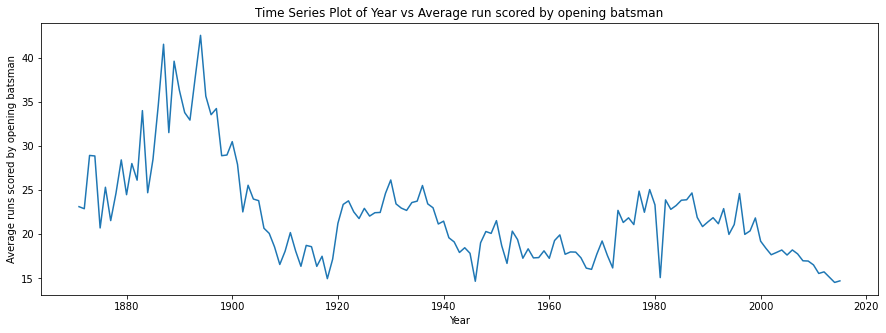

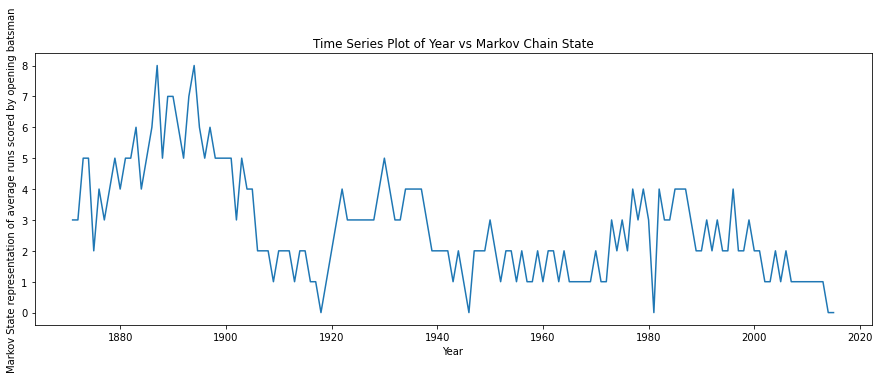

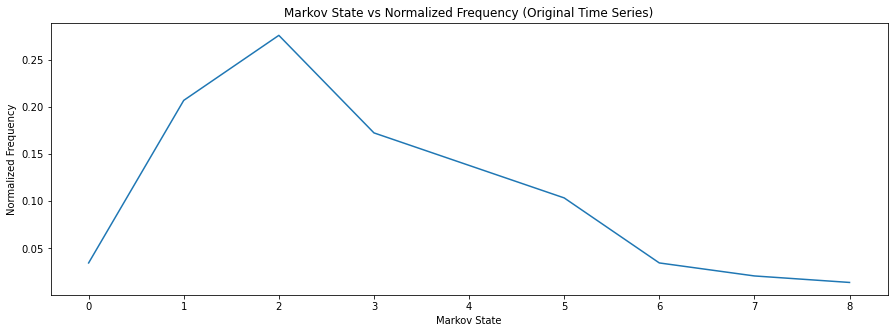

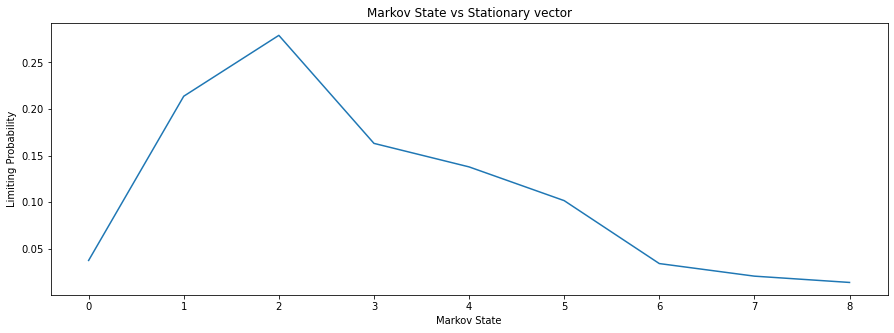

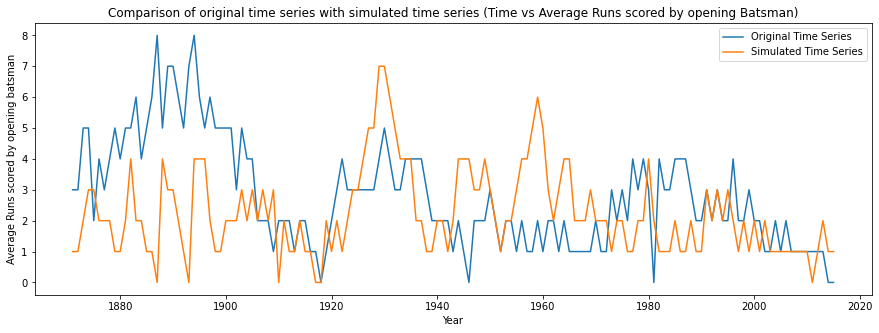

Matrix([
[ 1.01899781532406,     1.00551149232414],
[ 0.79605409610395,    0.688973351458996],
[0.749135115365546,    0.517098768054778],
[0.736988711685739,    0.336070473342256],
[0.679027650044939,    0.296089147154145],
[  0.6513990516059,    0.262492971088446],
[0.608371406607196,    0.218047028213178],
[0.587511071612848,    0.083186361924827],
[0.527604342102199, -0.00104205925219773],
[  0.4696432804614,  -0.0752687413702859]])

(Decision Threshold, TS for state 0) = (7.814727903251179, 28.5)   Rejecting State 0
(Decision Threshold, TS for state 1) = (7.814727903251179, 157.7253401360544)   Rejecting State 1
(Decision Threshold, TS for state 2) = (7.814727903251179, 70.21227564102563)   Rejecting State 2
(Decision Threshold, TS for state 3) = (9.487729036781154, 141.50464629629627)   Rejecting State 3
(Decision Threshold, TS for state 4) = (7.814727903251179, 148.60524691358023)   Rejecting State 4
(Decision Threshold, TS for state 5) = (11.070497693516351, 104.23495726495725)   Rejecting State 5
(Decision Threshold, TS for state 6) = (5.991464547107979, 3.6533333333333333)   Accepting State 6
(Decision Threshold, TS for state 7) = (5.991464547107979, 14.666666666666664)   Rejecting State 7
(Decision Threshold, TS for state 8) = (3.841458820694124, 2.5)   Accepting State 8


In [270]:
GAP = 4

df = pd.read_csv("./Baseball/Batting.csv")
df = df[(df.stint == 1) & (df.R >= 0)]

all_years_runs = pd.pivot_table(df, index = ["yearID"], values = ["R"], aggfunc = np.average)
all_years_runs = all_years_runs.sort_values(by = ["yearID"])

old_runs = all_years_runs["R"]

# print(np.mean(old_runs))
# print(np.median(old_runs))
# print(old_runs.quantile([0, 0.02, 0.05, 0.1, 0.25, 0.4, 0.5, 0.65, 0.8, 0.95, 1]))
# print(len(old_runs))

# quantiles = old_runs.quantile([0.01, 0.05, 0.1, 0.22, 0.30, 0.56, 0.8, 0.89, 0.96, 0.99, 1]).to_list()

quantiles = old_runs.quantile([0.03, 0.24, 0.52, 0.69, 0.83, 0.935, 0.97, 0.99, 1.0]).to_list()

plt.figure(figsize = (15, 5))
plt.title("Time Series Plot of Year vs Average run scored by opening batsman")
plt.xlabel("Year")
plt.ylabel("Average runs scored by opening batsman")
plt.plot(old_runs)
plt.show()

r_min, r_max = old_runs.min(), old_runs.max()



all_years_runs["R"] = np.where((all_years_runs["R"] > 0) & (all_years_runs["R"] <= quantiles[0]), 1, all_years_runs["R"])
all_years_runs["R"] = np.where((all_years_runs["R"] > quantiles[0]) & (all_years_runs["R"] <= quantiles[1]), 2, all_years_runs["R"])
all_years_runs["R"] = np.where((all_years_runs["R"] > quantiles[1]) & (all_years_runs["R"] <= quantiles[2]), 3, all_years_runs["R"])
all_years_runs["R"] = np.where((all_years_runs["R"] > quantiles[2]) & (all_years_runs["R"] <= quantiles[3]), 4, all_years_runs["R"])
all_years_runs["R"] = np.where((all_years_runs["R"] > quantiles[3]) & (all_years_runs["R"] <= quantiles[4]), 5, all_years_runs["R"])
all_years_runs["R"] = np.where((all_years_runs["R"] > quantiles[4]) & (all_years_runs["R"] <= quantiles[5]), 6, all_years_runs["R"])
all_years_runs["R"] = np.where((all_years_runs["R"] > quantiles[5]) & (all_years_runs["R"] <= quantiles[6]), 7, all_years_runs["R"])
all_years_runs["R"] = np.where((all_years_runs["R"] > quantiles[6]) & (all_years_runs["R"] <= quantiles[7]), 8, all_years_runs["R"])
all_years_runs["R"] = np.where((all_years_runs["R"] > quantiles[7]) & (all_years_runs["R"] <= quantiles[8]), 9, all_years_runs["R"])


m, M = all_years_runs.index.min(), all_years_runs.index.max()
all_years_runs["RCount"] = all_years_runs["R"].map(all_years_runs["R"].value_counts())
all_years_runs["RCount_norm"] = all_years_runs["R"].map(all_years_runs["R"].value_counts(normalize = True))
label_encoder = preprocessing.LabelEncoder()
all_years_runs["MC_R"] = label_encoder.fit_transform(all_years_runs["R"])


run_series = all_years_runs["MC_R"]

plt.figure(figsize = (15, 5))
plt.title("Time Series Plot of Year vs Markov Chain State")
plt.xlabel("Year")
plt.ylabel("Markov State representation of average runs scored by opening batsman")
plt.plot(run_series)
plt.show()

all_years_runs_no_dup = all_years_runs.drop_duplicates().sort_values(by = "R")

x = all_years_runs_no_dup["MC_R"]
y = all_years_runs_no_dup["RCount_norm"]
f = interp1d(x, y)
f2 = interp1d(x, y, kind = "cubic")

plt.figure(figsize = (15, 5))
plt.title("Markov State vs Normalized Frequency (Original Time Series)")
plt.xlabel("Markov State")
plt.ylabel("Normalized Frequency")
plt.plot(x, f2(x))
plt.show()



total_states = all_years_runs_no_dup["R"].count()
P, N1 = compute_transition_matrix_fast(run_series.tolist(), total_states, 1)
W = compute_stationary_distribution(P)

plt.figure(figsize = (15, 5))
plt.title("Markov State vs Stationary vector")
plt.xlabel("Markov State")
plt.ylabel("Limiting Probability")
plt.plot(all_years_runs_no_dup["MC_R"], W)
plt.show()

m_MC_R, M_MC_R = all_years_runs_no_dup["MC_R"].min(), all_years_runs_no_dup["MC_R"].max()

new_run_series = pd.Series()
new_run_series.at[m] = np.random.choice(np.arange(m_MC_R, M_MC_R + 1))
for i in range(m + 1, M + 1):
    prev = new_run_series[i - 1]
    curr = np.random.choice(np.arange(m_MC_R, M_MC_R + 1), p = P[prev])
    new_run_series.at[i] = curr

plt.figure(figsize = (15, 5))
plt.title("Comparison of original time series with simulated time series (Time vs Average Runs scored by opening Batsman)")
plt.xlabel("Year")
plt.ylabel("Average Runs scored by opening batsman")
ax1 = plt.plot(run_series, label = "Original Time Series")
ax2 = plt.plot(new_run_series, label = "Simulated Time Series")
plt.legend()
plt.show()


R = np.zeros((10, 2))

for i in range(10):
    R[i][0] = compute_auto_correlation(run_series, i)
    R[i][1] = compute_auto_correlation(new_run_series, i)

display(sp.Matrix(R))

# print()

Q_emp, N2 = compute_transition_matrix_fast(run_series.tolist(), total_states, 2)

Q_th = P**2

decision_threshold = sc.stats.chi2.ppf(q = 0.95, df = total_states - 1)

# display("Decision Threshold (chi^2) = " + str(decision_threshold))
# print()

for i in range(total_states):
    a, b = get_test_statistic(N2, Q_th, i)
    print("(Decision Threshold, TS for state " + str(i) + ") = (" + str(a) + ", " + str(b) + ")   " + ("Rejecting State " + str(i) if b > a else "Accepting State " + str(i)))



In [262]:
for i in range(len(quantiles)):
    print(old_runs[old_runs <= quantiles[i]].size)

145
145
145
145
145
145
145
145
145


In [257]:
pretty_print_matrix(W)

   0.037 
   0.214 
   0.279 
   0.163 
   0.138 
   0.101 
   0.034 
   0.020 
   0.014 


In [268]:
W.transpose()[0]

array([0.03719128, 0.2137202 , 0.27916343, 0.16303602, 0.13775113,
       0.10148277, 0.03382759, 0.02029655, 0.01353104])